<a href="https://colab.research.google.com/github/gagan0183/pytorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch workflow

Let's explore an example PyTorch end-to-end workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for netural networks
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.0.1+cu118'

# 1. Data (preparation and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known *parameters*.

In [3]:
# create known parameters
weight = 0.7
bias = 0.3

# create
start = 0 
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

create a training and test set with our data

In [5]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data ?

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data,, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # PLot test data in screen
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are their predictions
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

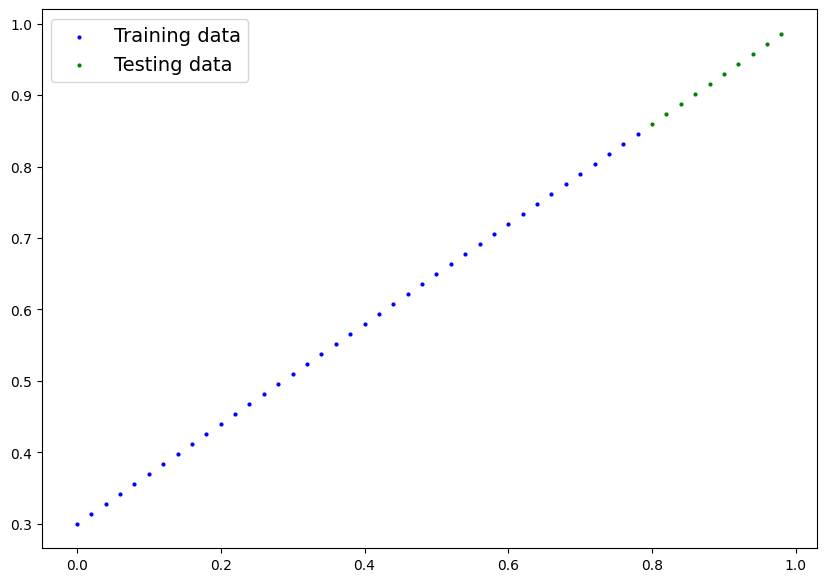

In [7]:
plot_predictions()

Build model

What our model do:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do:
1. Gradient descent
2. Backpropagation

In [8]:
from torch import nn

# create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # can this parameter be updated via gradient descent
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor: # <- x is the input data
    return self.weights * x + self.bias # this is the linear regression formula

from torch.autograd import forward_ad
## pytorch model building essentials

* torch.nn - contains all the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - parameters should our model try and learn, oftern a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural networks, if you subclass it, you should overwrite forward
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses required you to overwrite.

### checking the contents of our pytorch model

How we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using .parameters().

In [9]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.config/

When we pass data through our model, it's going to run it through forward function

In [11]:
# make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

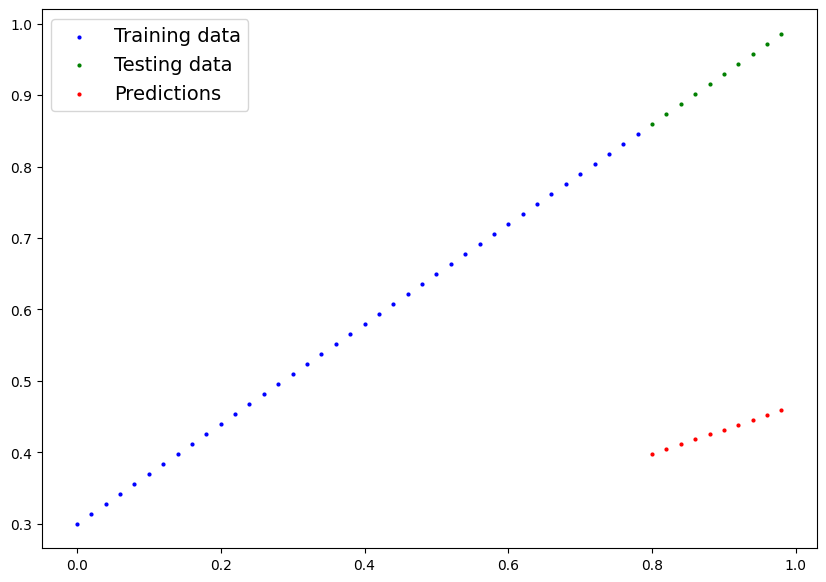

In [13]:
plot_predictions(predictions=y_preds)

### Train model

The whole idea of training is for a model to move from some *unknown* parameters (this may be random) to *known* parameters

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are to use loss function

* Note: Loss function may be also be called cost function or criterion in different case.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's preductions are to the ideal output
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (weight & bias)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) # learning rate - possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data and then perform the below points
1. forward pass (this involves data moving through our models's `forward()` functions) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [16]:
torch.manual_seed(42)
# An epoch is one loop through the data.. (this is a hyperparameter because we set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train model in PyTorch sets the parameters that require gradients to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optmizier zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagaion on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.. we have to zero them above in step 3 for the next iteration of the loop

  model_0.eval() # turns off the different settings in the model not needed for evaluation/testing

  with torch.inference_mode(): # turns off gradient tracking & a couple of more things behind the scenes
    # 1. do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

Q. Which loss function and optimizer should we use?
A. This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours) a loss function of nn.L1Loss() and optimizer like torch.optim.SGD() will suffice.

But for a classification problem like classification whether a photo is of a dog or a cat, you'll likely want to use a loss function of nn.BCELoss() (binary cross entropy loss)

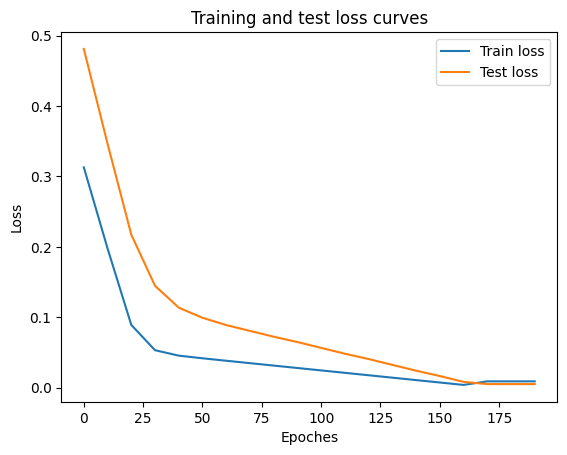

In [17]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend()

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

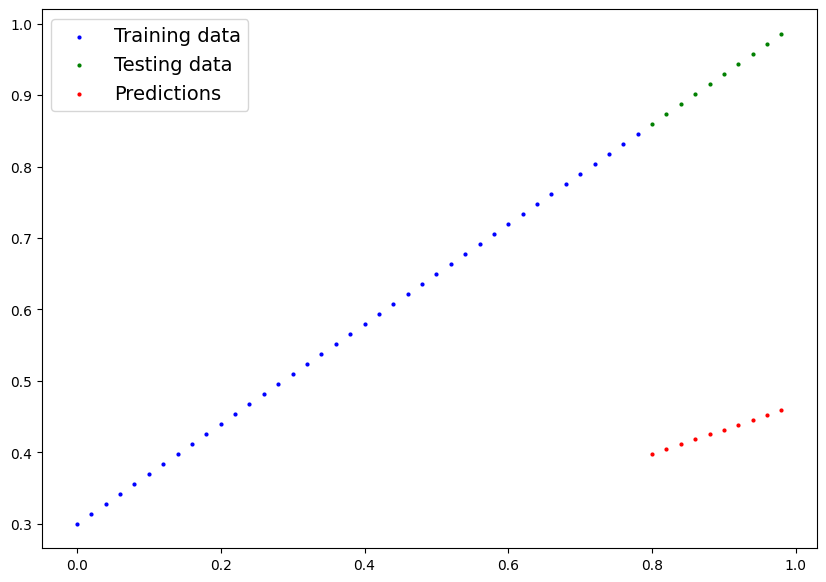

In [19]:
plot_predictions(predictions=y_preds)

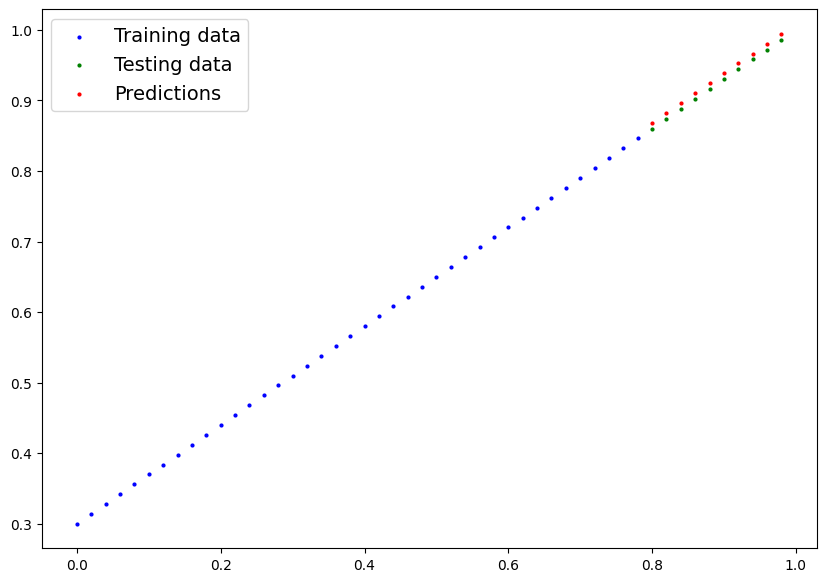

In [20]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch

1. `torch.save()` - allows you save a PyTorch object in Pythin's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [21]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [22]:
!ls -ls models/

total 4
4 -rw-r--r-- 1 root root 1207 Jun 19 22:32 01_pytorch_workflow_model_0.pth


# Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [23]:
# To load in saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this wil update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [26]:
# make some model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [27]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

#6. Putting it all together
Let's go back through the steps above and see it all in one place

In [28]:
# import PyTorch and matplotlib

import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.0.1+cu118'

Create device-agnostic code.

This means if we got access to a GPU, our code will use it (for potentially faster computing)

If no GPU is available, the code with default to CPU

In [29]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cpu


## 6.1 Data

In [30]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, will pop errors in case not used this
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [31]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

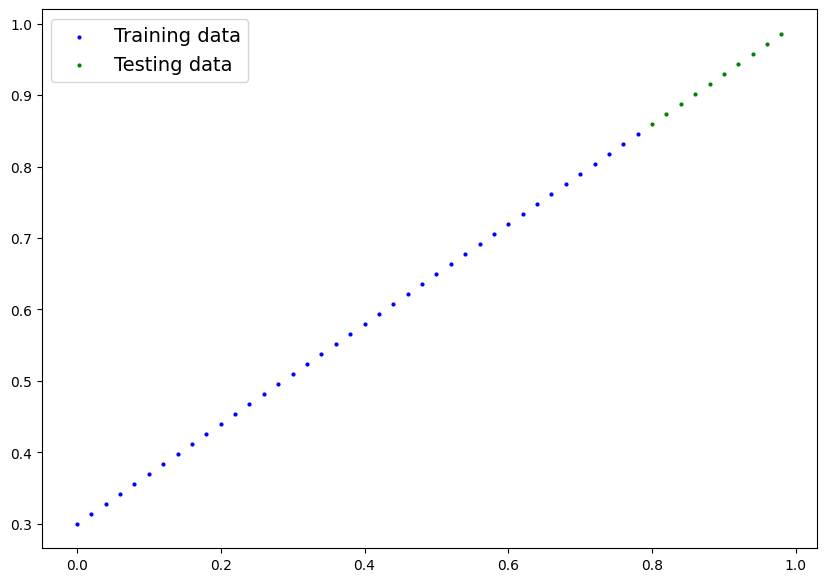

In [32]:
# Plot the data
# Note. if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model

In [35]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters, also called: linear transform, probing layer, full connected layer, dense leyer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x: torch.tensor) -> torch.Tensor:
    return self.linear_layer(x)
  

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [38]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [41]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [42]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.001)

In [50]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  # 1. forward pass
  y_pred = model_1(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropagation
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.006145041435956955 | Test loss: 0.014290553517639637
Epoch: 10 | Loss: 0.005801583640277386 | Test loss: 0.013497531414031982
Epoch: 20 | Loss: 0.005457866005599499 | Test loss: 0.012670164927840233
Epoch: 30 | Loss: 0.0051141902804374695 | Test loss: 0.01191144622862339
Epoch: 40 | Loss: 0.004771321080625057 | Test loss: 0.011084062047302723
Epoch: 50 | Loss: 0.004427430219948292 | Test loss: 0.010256713256239891
Epoch: 60 | Loss: 0.004083932377398014 | Test loss: 0.009498000144958496
Epoch: 70 | Loss: 0.0037408978678286076 | Test loss: 0.008670640178024769
Epoch: 80 | Loss: 0.003396999789401889 | Test loss: 0.00784327369183302
Epoch: 90 | Loss: 0.003053670283406973 | Test loss: 0.007084542419761419
Epoch: 100 | Loss: 0.002710457891225815 | Test loss: 0.006257194094359875
Epoch: 110 | Loss: 0.0023665553890168667 | Test loss: 0.0054298462346196175
Epoch: 120 | Loss: 0.0020234123803675175 | Test loss: 0.00467111449688673
Epoch: 130 | Loss: 0.0016797177959233522 | Test

In [51]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]])),
             ('linear_layer.bias', tensor([0.3008]))])

## 6.4 Making and evaluating predictions

In [52]:
# Turn model into evaluation model
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8607],
        [0.8747],
        [0.8887],
        [0.9027],
        [0.9167],
        [0.9307],
        [0.9447],
        [0.9587],
        [0.9727],
        [0.9867]])

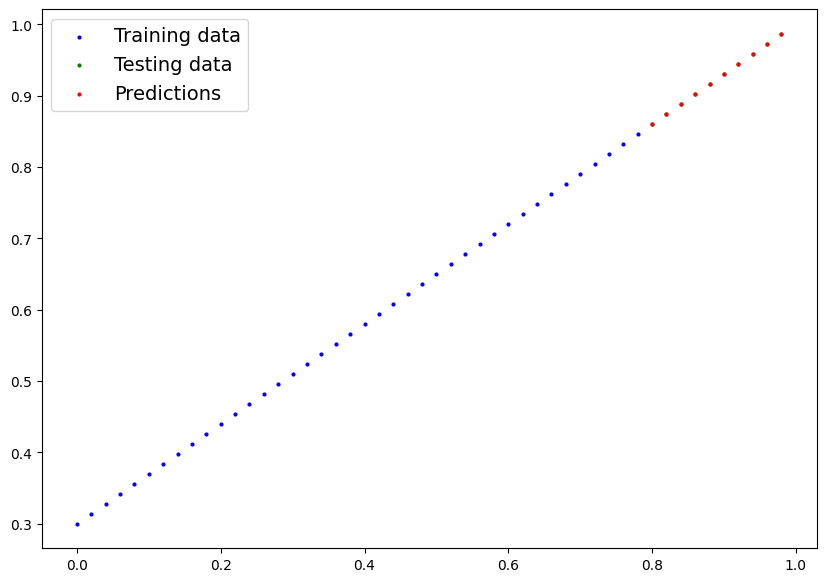

In [53]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds)

## 6.5 Saving and loading a trained model

In [54]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [56]:
# Load a PyTorch model

# Create a new instance of linear regression model: V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [59]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]])),
             ('linear_layer.bias', tensor([0.3008]))])

In [63]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)
loaded_model_preds

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])